In [ ]:
from nltk import download as nltk_download

nltk_download('punkt')
nltk_download('averaged_perceptron_tagger')
nltk_download('wordnet')

In [46]:
from bs4 import BeautifulSoup as Soup
import logging
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from os import path
from PyPDF2 import PdfReader
import string
from typing import Iterable, List, Tuple

lem = WordNetLemmatizer()

logger = logging.getLogger("PyPDF2")
logger.setLevel(logging.ERROR)

def extract_html_tokens(file_path: str) -> str:
    soup = None
    with open(file_path, 'rb') as f:
        soup = Soup(f, 'html.parser')

    for script in soup(["script", "style"]):
        script.extract()

    return soup.get_text()

def extract_pdf_tokens(file_path: str) -> str:
    text = ''
    reader = PdfReader(file_path)
    for page in reader.pages:
        text = text + "\n" + page.extract_text()

    return text

def extract_tokens(file_path: str) -> List[str]:
    EXTRACTORS = {
        '.html': extract_html_tokens,
        '.pdf': extract_pdf_tokens,
    }
    
    try:
        extension = path.splitext(file_path)[-1].lower()
        text = EXTRACTORS[extension](file_path)

        text = (
            text
                .replace('—', '-')
                .replace('“', '"')
                .replace('”', '"')
                .replace('’', '\'')
        )

        return [
            token.lower().strip(string.punctuation)
            for token in word_tokenize(text)
            if (
                token
                and token not in string.punctuation
                and not token.replace('.', '').isnumeric()
                and token.lower().strip(string.punctuation)
            )
        ]
    except Exception as e:
        print(f'Failed to extract {file_path}: {e}')
        return []
    
def retag_for_wordnet(tagged_pair: Tuple[str, str]) -> Tuple[str, str]:
    def get_wordnet_pos(treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN
    
    word, tag = tagged_pair
    return (word, get_wordnet_pos(tag))

def tokens_from_file(file_path: str) -> Iterable[str]:
    return (
        lem.lemmatize(*retag_for_wordnet(tagpair))
        for tagpair
        in (pos_tag(extract_tokens(file_path)))
    )

In [66]:
from glob import glob
from itertools import chain, islice
from nltk import FreqDist
import sys

bills = glob('../tmp/neutral_corpus/bills/*')
canonicalized_tokens = chain.from_iterable(
    tokens_from_file(bill)
    for bill
    in bills
)

distribution = FreqDist(islice(canonicalized_tokens, sys.maxsize))

Failed to extract ../tmp/neutral_corpus/bills/empty: ''


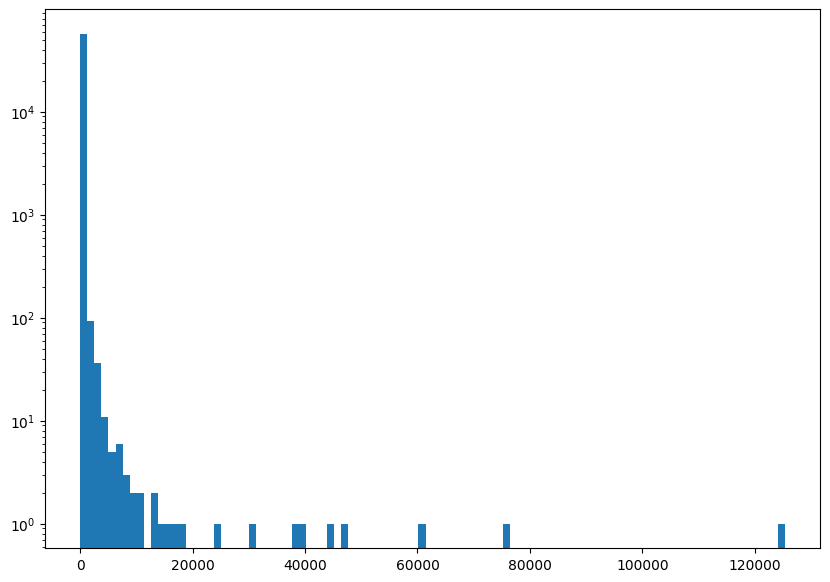

In [67]:
from matplotlib import pyplot as plt

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist([val for val in distribution.values() if val > 0], bins=100)
plt.yscale('log')
 
# Show plot
plt.show()

In [91]:
import json

stoplist = list(
    k
    for k, v in distribution.items()
    if v > 800
)

print(len(stoplist))
# 100*len(stoplist)/len(distribution.keys())

with open('../artifacts/legal_stopwords.json', 'w') as f:
    json.dump(stoplist, f, indent=2)

298


In [85]:
from wordcloud import STOPWORDS
len(STOPWORDS)

192